<a href="https://colab.research.google.com/github/kkt86/quant-notebooks/blob/master/DevNet_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DevNet

Notebook, reproducing the results from Deep Anomaly Detection with Deviation Networks paper (https://paperswithcode.com/paper/deep-anomaly-detection-with-deviation)

In [20]:
%pip install tensorflow==1.10.1 keras==2.2.2

     |████████████████████████████████| 58.4MB 49kB/s 
     |████████████████████████████████| 307kB 47.7MB/s 
     |████████████████████████████████| 12.2MB 257kB/s 
     |████████████████████████████████| 3.3MB 53.7MB/s 
     |████████████████████████████████| 573kB 44.3MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
ERROR: xarray 0.15.1 has requirement numpy>=1.15, but you'll have numpy 1.14.5 which is incompatible.
ERROR: xarray 0.15.1 has requirement setuptools>=41.2, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.14.5 which is incompatible.
ERROR: tifffile 2020.7.24 has requirement numpy>=1.15.1, but you'll have numpy 1.14.5 which is incompatible.
ERROR: spacy 2.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: plotnine 0.6.0 has requirement numpy>=1.16.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: numba 0.48.0 has requirem

In [1]:
import tensorflow as tf
import keras

print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Tensorflow version: 1.10.1
Keras version: 2.2.2


Using TensorFlow backend.


### Load credit card transaction data

In [2]:
import pandas as pd

creditcard_data = pd.read_csv("drive/My Drive/colab data/creditcard.csv")
creditcard_data = creditcard_data.drop("Time", axis=1)

creditcard_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# split and preprocess data
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

feature_cols = [col for col in creditcard_data.columns if col != "Class"]
target_col = "Class"

insample_X, outsample_X, insample_y, outsample_y = train_test_split(creditcard_data[feature_cols], 
                                                                    creditcard_data[target_col], 
                                                                    train_size=0.8, 
                                                                    stratify=creditcard_data["Class"])

print(f"Train data shape: {insample_X.shape}")
print(f"Test data shape : {outsample_X.shape}")
print(f"Positive values in train: {sum(insample_y == 1)}")
print(f"Positive values in test : {sum(outsample_y == 1)}")
print(f"Percentage positive values in train: {round(100*sum(insample_y == 1)/len(insample_y), 3)}")
print(f"Percentage positive values in test : {round(100*sum(outsample_y == 1)/len(outsample_y), 3)}")

# scale values in range [0,1]
insample_X = minmax_scale(insample_X)
outsample_X = minmax_scale(outsample_X)

Train data shape: (227845, 29)
Test data shape : (56962, 29)
Positive values in train: 394
Positive values in test : 98
Percentage positive values in train: 0.173
Percentage positive values in test : 0.172


### Main training loop

In [13]:
def inject_noise(seed, n_out, random_seed):
  """
  add anomalies to training data to replicate anomaly contaminated data sets.
  we randomly swape 5% features of anomalies to avoid duplicate contaminated anomalies.
  this is for dense data
  """
  rng = np.random.RandomState(random_seed) 
  n_sample, dim = seed.shape
  swap_ratio = 0.05
  n_swap_feat = int(swap_ratio * dim)
  noise = np.empty((n_out, dim))
  for i in np.arange(n_out):
    outlier_idx = rng.choice(n_sample, 2, replace = False)
    o1 = seed[outlier_idx[0]]
    o2 = seed[outlier_idx[1]]
    swap_feats = rng.choice(dim, n_swap_feat, replace = False)
    noise[i] = o1.copy()
    noise[i, swap_feats] = o2[swap_feats]
  return noise

In [28]:
from keras import regularizers
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard

def dev_network_linear(input_shape):
  '''
  network architecture with no hidden layer, equivalent to linear mapping from
  raw inputs to anomaly scores
  '''    
  x_input = Input(shape=input_shape)
  intermediate = Dense(1, activation='linear',  name = 'score')(x_input)
  return Model(x_input, intermediate)

def dev_network_s(input_shape):
  """
  network architecture with one hidden layer
  """
  x_input = Input(shape=input_shape)
  intermediate = Dense(20, activation="relu", kernel_regularizer=regularizers.l2(0.01), name="hl1")(x_input)
  intermediate = Dense(1, activation="linear", name="score")(intermediate)
  return Model(x_input, intermediate)

def dev_network_d(input_shape):
  """
  network architecture with three hidden layers
  """
  x_input = Input(shape=input_shape)
  intermediate = Dense(1000, activation="relu", kernel_regularizer=regularizers.l2(0.01), name="hl1")(x_input)
  intermediate = Dense(250, activation="relu", kernel_regularizer=regularizers.l2(0.01), name="hl2")(intermediate)
  intermediate = Dense(20, activation="relu", kernel_regularizer=regularizers.l2(0.03), name="hl3")(intermediate)
  intermediate = Dense(1, activation="linear", name="score")(intermediate)
  return Model(x_input, intermediate)

def deviation_loss(y_true, y_pred):
  '''
  z-score-based deviation loss
  '''    
  confidence_margin = 5.     
  ## size=5000 is the setting of l in algorithm 1 in the paper
  ref = K.variable(np.random.normal(loc = 0., scale= 1.0, size = 5000) , dtype='float32')
  dev = (y_pred - K.mean(ref)) / K.std(ref)
  inlier_loss = K.abs(dev) 
  outlier_loss = K.abs(K.maximum(confidence_margin - dev, 0.))
  return K.mean((1 - y_true) * inlier_loss + y_true * outlier_loss)

def deviation_network(input_shape, network_depth):
  '''
  construct the deviation network-based detection model
  '''
  if network_depth == 4:
      model = dev_network_d(input_shape)
  elif network_depth == 2:
      model = dev_network_s(input_shape)
  elif network_depth == 1:
      model = dev_network_linear(input_shape)
  else:
      sys.exit("The network depth is not set properly")
  rms = RMSprop(clipnorm=1.)
  model.compile(loss=deviation_loss, optimizer=rms)
  return model

In [29]:
def batch_generator_sup(x, outlier_indices, inlier_indices, batch_size, nb_batch, rng):
  """
  batch generator
  """
  rng = np.random.RandomState(rng.randint(MAX_INT, size = 1))
  counter = 0
  while 1:                
    ref, training_labels = input_batch_generation_sup(x, outlier_indices, inlier_indices, batch_size, rng)
    counter += 1
    yield(ref, training_labels)
    if (counter > nb_batch):
        counter = 0
 
def input_batch_generation_sup(x_train, outlier_indices, inlier_indices, batch_size, rng):
    '''
    batchs of samples. Alternates between positive and negative pairs.
    '''      
    dim = x_train.shape[1]
    ref = np.empty((batch_size, dim))    
    training_labels = []
    n_inliers = len(inlier_indices)
    n_outliers = len(outlier_indices)
    for i in range(batch_size):    
      if(i % 2 == 0):
        sid = rng.choice(n_inliers, 1)
        ref[i] = x_train[inlier_indices[sid]]
        training_labels += [0.]
      else:
        sid = rng.choice(n_outliers, 1)
        ref[i] = x_train[outlier_indices[sid]]
        training_labels += [1.]
    return np.array(ref), np.array(training_labels)

In [30]:
from sklearn.metrics import average_precision_score, roc_auc_score

def aucPerformance(mse, labels):
  roc_auc = roc_auc_score(labels, mse)
  ap = average_precision_score(labels, mse)
  print("AUC-ROC: %.4f, AUC-PR: %.4f" % (roc_auc, ap))
  return roc_auc, ap;

In [31]:
def load_model_weight_predict(model_name, input_shape, network_depth, x_test):
  '''
  load the saved weights to make predictions
  '''
  model = deviation_network(input_shape, network_depth)
  model.load_weights(model_name)
  scoring_network = Model(inputs=model.input, outputs=model.output)    
  scores = scoring_network.predict(x_test)
  return scores

In [97]:
import time

MAX_INT = np.iinfo(np.int32).max

batch_size = 512      # batch size used in SGD
cont_rate = 0.02      # the outlier contamination rate in the training data
epochs = 50           # the number of epochs
known_outliers = 1000 # the number of labeled outliers available at hand"
nb_batch = 20         # the number of batches per epoch
network_depth = 2     # the depth of the network architecture
random_seed = 42      # random seed number
runs = 10             # how many times we repeat the experiments to obtain the average performance

outlier_indices = np.where(insample_y == 1)[0]
outliers = insample_X[outlier_indices]  
n_outliers_org = outliers.shape[0] 

rng = np.random.RandomState(random_seed)
rauc = np.zeros(runs)
ap = np.zeros(runs) 

for run in np.arange(runs):
  x_train, x_test, y_train, y_test = train_test_split(insample_X, insample_y, 
                                                      test_size=0.2, 
                                                      random_state=random_seed, 
                                                      stratify=insample_y)
  y_train = np.array(y_train)
  y_test = np.array(y_test)
  outlier_indices = np.where(y_train == 1)[0]
  inlier_indices = np.where(y_train == 0)[0]
  n_outliers = len(outlier_indices)
  
  n_noise = len(np.where(y_train == 0)[0])*cont_rate / (1. - cont_rate)
  n_noise = int(n_noise)

  rng = np.random.RandomState(random_seed)

  # keep maximum number of outliers below 30 (try removing this)
  if n_outliers > known_outliers:
    mn = n_outliers - known_outliers
    remove_idx = rng.choice(outlier_indices, mn, replace=False)
    x_train = np.delete(x_train, remove_idx, axis=0)
    y_train = np.delete(y_train, remove_idx, axis=0)

  noises = inject_noise(outliers, n_noise, random_seed)
  x_train = np.append(x_train, noises, axis=0)
  y_train = np.append(y_train, np.zeros((noises.shape[0], 1)))

  outlier_indices = np.where(y_train == 1)[0]
  inlier_indices = np.where(y_train == 0)[0]

  input_shape = x_train.shape[1:]
  n_samples_trn = x_train.shape[0]
  n_outliers = len(outlier_indices)            

  start_time = time.time()
  input_shape = x_train.shape[1:]
  model = deviation_network(input_shape, network_depth)
  model_name = "./model/devnet_" + str(cont_rate) + "cr_"  + str(batch_size) +"bs_" + str(known_outliers) + "ko_" + str(network_depth) +"d.h5"
  checkpointer = ModelCheckpoint(model_name, monitor='loss', verbose=0, save_best_only = True, save_weights_only = True)

  model.fit_generator(batch_generator_sup(x_train, outlier_indices, inlier_indices, batch_size, nb_batch, rng), 
                      steps_per_epoch = nb_batch,
                      epochs = epochs,
                      callbacks=[checkpointer], verbose=0) 
  train_time = time.time() - start_time

  start_time = time.time()
  scores = load_model_weight_predict(model_name, input_shape, network_depth, x_test)
  test_time = time.time() - start_time
  rauc[run], ap[run] = aucPerformance(scores, y_test)

AUC-ROC: 0.9715, AUC-PR: 0.6761
AUC-ROC: 0.9719, AUC-PR: 0.6758
AUC-ROC: 0.9713, AUC-PR: 0.6802
AUC-ROC: 0.9729, AUC-PR: 0.6771
AUC-ROC: 0.9701, AUC-PR: 0.6769
AUC-ROC: 0.9687, AUC-PR: 0.6750
AUC-ROC: 0.9711, AUC-PR: 0.6807
AUC-ROC: 0.9699, AUC-PR: 0.6763
AUC-ROC: 0.9686, AUC-PR: 0.6757
AUC-ROC: 0.9716, AUC-PR: 0.6811


### Evaluate the model on the outsample data

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
%matplotlib inline

def plot_confusion_matrix(y_true, y_pred, norm=True):
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  if norm:
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    title = "Normalized confuzion matrix"
  else:
    cm = confusion_matrix(y_true, y_pred)
    title = "Confusion matrix"
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');
  ax.set_ylabel('True labels'); 
  title = title +  " Precision: " + str(round(precision, 2)) + " | Recall: " + str(round(recall, 2)) + " | F1-score: " + str(round(f1, 2))
  ax.set_title(title); 
  ax.xaxis.set_ticklabels(['0', '1']); 
  ax.yaxis.set_ticklabels(['1', '0']);
  plt.show()

In [99]:
outsample_scores = load_model_weight_predict(model_name, input_shape, network_depth, outsample_X)
outsample_pred = np.where(outsample_scores >= 5., 1, 0)

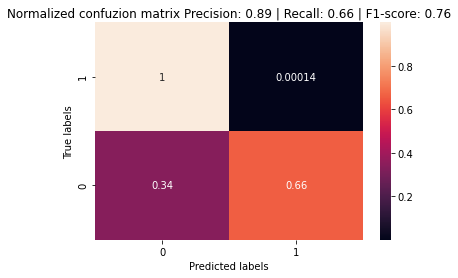

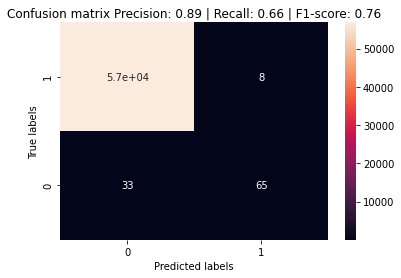

In [100]:
plot_confusion_matrix(outsample_y, outsample_pred)
plot_confusion_matrix(outsample_y, outsample_pred, norm=False)

### Compare with RandomForest implementation

In [101]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(insample_X, insample_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [102]:
rf_predict = rf.predict(outsample_X)

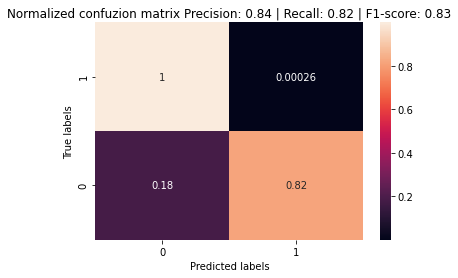

In [103]:
plot_confusion_matrix(outsample_y, rf_predict)